# Demo Script for Milestone 10.15

## 0 Prepare task

### 0.1 prepare planning scene

#### Run camera server on the camera computer (192.168.0.10, use vnc viewer)
```bash
python stream_server.py --ip='192.168.0.10' # camera pc ip
```

#### Run shared detector on bash
```bash
python3 /home/jhkim/Projects/rnb-planning/src/scripts/milestone_202110/utils/shared_detector.py
```

#### Check and request ip setting from mobile udp client (robot-side)

#### 0.1.1 Set parameters and create planning scene

In [1]:
import numpy as np

CONNECT_CAM = True
ENABLE_DETECT = True
ENABLE_O3D = True

CONNECT_INDY = True
CONNECT_MOBILE = True

VISUALIZE = False
PLANNING_MULTIPROC = True

ROS_MASTER_ON_MOBILE = False
# Tool dimensions
TOOL_DIM = [0.08, 0.32]
# TOOL_OFFSET = 0.01
TOOL_OFFSET = -0.0 # tested one
MARGIN = 0
TRACK_THICKNESS = 0.001

INDY_BASE_OFFSET = (0.172,0,0.439)
INDY_BASE_RPY = (0,0,0)
TOOL_NAME = "brush_face"
WALL_THICKNESS = 0.01
CLEARANCE = 0.001

IP_CUR = "192.168.0.8"# get_ip_address()
MOBILE_IP = "192.168.0.102"
INDY_IP = "192.168.0.3"
CAM_HOST = '192.168.0.10'

print("Current PC IP: {}".format(IP_CUR))
print("Mobile ROB IP: {}".format(MOBILE_IP))
print("CAM SERVER IP: {}".format(CAM_HOST))

Current PC IP: 192.168.0.8
Mobile ROB IP: 192.168.0.102
CAM SERVER IP: 192.168.0.10


In [2]:
import os
import sys
sys.path.append(os.path.join(os.path.join(
    os.environ["RNB_PLANNING_DIR"], 'src')))
sys.path.append(os.path.join(
    os.environ["RNB_PLANNING_DIR"], 'src/scripts/milestone_202110'))

from pkg.global_config import RNB_PLANNING_DIR
from pkg.utils.utils import *    
from pkg.utils.rotation_utils import *
from pkg.controller.combined_robot import *
from demo_utils.streaming import *
from demo_utils.detect_table import *
from demo_utils.area_select import *
from pkg.detector.aruco.marker_config import get_aruco_map
aruco_map = get_aruco_map()

from pkg.geometry.builder.scene_builder import SceneBuilder
from demo_utils.environment import *
from demo_utils.area_select import DATASET_DIR, SweepDirections

from utils.streaming import *
from utils.detection_util import *


from pkg.utils.shared_function import *
clear_channels_on("kiromobilemap")

mobile_config = RobotConfig(0, RobotType.kmb, ((0,0,0), (0,0,0)),
                "{}/{}".format(MOBILE_IP, IP_CUR), 
                            specs={"dummy":not CONNECT_MOBILE})
robot_config = RobotConfig(1, RobotType.indy7, 
                           (INDY_BASE_OFFSET, INDY_BASE_RPY),
                INDY_IP, root_on="kmb0_platform", 
                           specs={"no_sdk":True})
MOBILE_NAME = mobile_config.get_indexed_name()
ROBOT_NAME = robot_config.get_indexed_name()
crob = CombinedRobot(robots_on_scene=[mobile_config, robot_config]
              , connection_list=[True, CONNECT_INDY])

s_builder = SceneBuilder(None)
SceneBuilder.autostart_roscore = not ROS_MASTER_ON_MOBILE
gscene = s_builder.create_gscene(crob)

gtems = s_builder.add_robot_geometries(
    color=(1,1,1,0.2), display=True, collision=True)
gscene.set_workspace_boundary(
    -4, 8, -7, 7, -CLEARANCE, 3, thickness=WALL_THICKNESS)


from pkg.planning.scene import PlanningScene
pscene = PlanningScene(gscene, combined_robot=crob)

ROBOT_BASE = pscene.robot_chain_dict[ROBOT_NAME]['link_names'][0]
TIP_LINK = pscene.robot_chain_dict[ROBOT_NAME]["tip_link"]
MOBILE_BASE = pscene.robot_chain_dict[MOBILE_NAME]["tip_link"]
HOLD_LINK = MOBILE_BASE

viewpoint = add_cam(gscene, tool_link=TIP_LINK)
# add_indy_tool_kiro(gscene, tool_link=TIP_LINK, 
# face_name=TOOL_NAME, zoff=TOOL_OFFSET)

HOME_POSE = -crob.home_pose
HOME_DICT = list2dict(HOME_POSE, gscene.joint_names)

from pkg.planning.pipeline import PlanningPipeline
ppline = PlanningPipeline(pscene)

# Set planner
from pkg.planning.motion.moveit.moveit_planner import MoveitPlanner
from pkg.planning.filtering.grasp_filter import GraspChecker
mplan = MoveitPlanner(pscene, enable_dual=False, 
                      incremental_constraint_motion=True)
mplan.motion_filters = [GraspChecker(pscene)]
mplan.update_gscene()
gcheck = GraspChecker(pscene)
mplan.motion_filters = [gcheck]

mplan.reset_PRQdict(enable_PRQ=True, radii=5e-2)
for tip_dir, SWEEP_AXIS in [
    (SweepDirections.front, "Z"), (SweepDirections.front, "X"), (SweepDirections.up, "Z"), (SweepDirections.down, "Z")]:
    filename = SweepDirections.get_file_name(RobotType.indy7, tip_dir.name+SWEEP_AXIS)+"-PRQ.pkl"
    PRQ_PATH = os.path.join(DATASET_DIR, filename)
    try:
        Pos_Rotvec_Qlist_dict = load_pickle(PRQ_PATH)
        mplan.register_PRQ(ROBOT_NAME, Pos_Rotvec_Qlist_dict, decimal=2)
        print("Loaded: {}".format(filename))
    except:
        print("File not exist: {}".format(filename))
        continue

from pkg.planning.task.rrt import TaskRRT
tplan = TaskRRT(pscene)
tplan.prepare()
ppline.set_motion_planner(mplan)
ppline.set_task_planner(tplan)


add_kiro_indytool_down(gscene, zoff=TOOL_OFFSET, 
                       tool_link=TIP_LINK, face_name=TOOL_NAME)

# Register binders
from pkg.planning.constraint.constraint_actor import VacuumTool, \
    Gripper2Tool, PlacePlane, SweepFramer

brush_face = pscene.create_binder(
    bname=TOOL_NAME, gname=TOOL_NAME, _type=SweepFramer, 
    point=(0,0, -gscene.NAME_DICT['brush_face'].dims[2]/2-CLEARANCE), 
    rpy=(0,0,0))

gscene.create_safe(
    gtype=GEOTYPE.BOX, name="floor_box", link_name="base_link",
    dims=(15,15,0.4), center=(0,0,0), rpy=(0,0,0), 
    color=(1, 1, 1, 0.1), display=True, collision=False, fixed=True)

gscene.add_highlight_axis("hl", "base_coord", T=np.identity(4), dims=(0.5,0.1,0.1))

kmb = crob.robot_dict["kmb0"]
indy = crob.robot_dict["indy1"]
mobile_box = gscene.NAME_DICT['kmb0_platform_Box_2']

if CONNECT_MOBILE:
    assert np.sum(np.abs(get_xyzw_cur()))>1e-4, "UDP Server not connected"

connection command:
kmb0: True
indy1: True
[MOBILE ROBOT] bind: ('192.168.0.8', 50306)
[MOBILE ROBOT] Start UDP THREAD
Connect: Server IP (192.168.0.3)
Unable to register with master node [http://localhost:11311]: master may not be running yet. Will keep trying.
Please create a subscriber to the marker
publication OK
published: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Please create a subscriber to the marker
Loaded: indy7-frontZ-PRQ.pkl
Loaded: indy7-frontX-PRQ.pkl
Loaded: indy7-upZ-PRQ.pkl
Loaded: indy7-downZ-PRQ.pkl


#### 0.1.2 Load environment map

In [3]:
from demo_utils.ros_map_utils import KiroMobileMap
kmm = KiroMobileMap(MOBILE_IP, IP_CUR, CONNECT_MOBILE)
            
VALID_BOX_SCALE = 0.7
VALID_SCORE_CUT = 50 
kmb.validifier = (lambda Q: 
                  np.max(
                      kmm.get_box_costs(mobile_box, Q, kmm.T_bi, kmm.cost_im, kmm.resolution, 
                                        scale=VALID_BOX_SCALE))<VALID_SCORE_CUT)
kmm.init_node(timeout=10)

In [4]:
pole_pt_list, pole_res = kmm.update_map(gscene, crob, MOBILE_BASE, timeout=100)

Connect: Server IP (192.168.0.3)
[WARN] Vertices for mesh should be have center point (0,0,0). Auto adjusting.


## 1. Detect scene

### 1.0 Wait task start queue

### 1.1 Detect bed

In [5]:
from utils.shared_detector import SharedDetector
sd = SharedDetector()
if ENABLE_DETECT:
    sd.init()

#### 1.1.1 Move to bed-seek pose 

In [6]:
Q_CUR = kmb.get_qcur()

VIEW_POSE = np.deg2rad([  0., 50.,  -70.,  -0.,  -90., 0])
VIEW_LOC = list(Q_CUR[:6])
VIEW_POSE_EXT = np.array(VIEW_LOC + list(VIEW_POSE))
if CONNECT_INDY:
    with indy:
        indy.joint_move_to(np.rad2deg(VIEW_POSE))
        time.sleep(0.5)
        indy.wait_for_move_finish()
        Qcur = np.deg2rad(indy.get_joint_pos())
else:
    Qcur = VIEW_POSE
gscene.show_pose(VIEW_POSE_EXT)

Connect: Server IP (192.168.0.3)
Move finished!


Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)


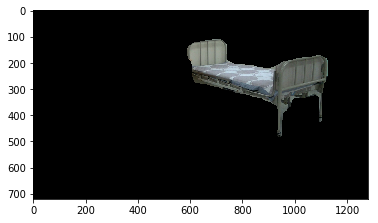

In [7]:
turn_dir = 1
Q0 = np.rad2deg(VIEW_POSE_EXT[6:])
dQ = np.zeros(6)
while True:
    # Take a picture again after rotate
    if CONNECT_CAM:
        rdict = stream_capture_image(
            ImageType.FirstView, obj_type="bed", host=CAM_HOST,
            crob=crob)
    else:
        rdict, VIEW_POSE_EXT = load_rdict("bed")
        

    cdp = rdict2cdp(rdict)
        
    
    if ENABLE_DETECT:
        # Output of inference(mask for detected table)
        mask_out = sd.inference(color_img=rdict['color'])
        cv2.imwrite(os.path.join(SAVE_DIR, "mask_bed.png"), mask_out)
    else:
        mask_out = cv2.imread(os.path.join(SAVE_DIR, "mask_bed.png"))[:,:,0]
        
    if np.any(mask_out):
        cdp_masked = apply_mask(cdp, mask_out)
        plt.imshow(cdp_masked.color[:,:,[2,1,0]])
        break
    if CONNECT_INDY:
        with indy:
            turn_dir *= -1
            dQ = np.add(dQ, [5,0,0,0,0,0])
            Qto = Q0+turn_dir*dQ
            Qto[0] = (Qto[0]+180/2)%180-180/2
            indy.joint_move_to(Qto)
            indy.wait_motion()
            VIEW_POSE_EXT[6:] = np.deg2rad(indy.get_joint_pos())

#### 1.1.2  detect bed and add to the scene

In [8]:
from pkg.utils.utils import *
gtimer = GlobalTimer.instance()

In [9]:
VISUALIZE = False
T_bc = viewpoint.get_tf(VIEW_POSE_EXT)
T_bc_bed_view = np.copy(T_bc)
T_cb = SE3_inv(T_bc)
gscene.show_pose(VIEW_POSE_EXT)
if ENABLE_O3D:
    icp_bed = MultiICP(model=MODEL_DIR + '/bed/bed.STL', 
                       Toff=SE3([[0,1,0],[0,0,1],[1,0,0]], [0.455,0,1.02]))
    # Try ICP1
    if np.any(mask_out):
        pcd = icp_bed.add_image(cdp_masked, Tc=None)

        Tguess = icp_bed.get_initial_by_center(R=np.matmul(T_cb[:3,:3], Rot_axis(3,np.pi)), 
                                               offset=np.matmul(T_cb[:3,:3], (1.1*0.7,0,-0.6)))
        
        with gtimer.block("ICP"):
            Tbs1, fitness1 = icp_bed.compute_ICP(To=Tguess, thres=0.15, visualize=VISUALIZE)
            Tbs2, fitness2 = icp_bed.compute_ICP(None, thres=0.15, visualize=VISUALIZE)
        
    # Better result is adopted
    T_co_bed = Tbs1 if fitness1 > fitness2 else Tbs2
    T_bo_bed = np.matmul(T_bc, T_co_bed)
    
    bed_center = T_bo_bed[:3,3]
    T_bo_new = align_z(T_bo_bed)
    bed_rpy = Rot2rpy(T_bo_new[:3,:3])

    # adjust
    bed_center[2]=0
    if Rot_rpy(bed_rpy)[0,0] > 0:
        bed_rpy[2] += np.pi

    bed_mat = add_bed(gscene, bed_center, bed_rpy, (0,1,0,0.3))
    if VISUALIZE: # show final result
        icp_bed.draw(np.matmul(T_cb, gscene.NAME_DICT["bed_vis"].get_tf(VIEW_POSE_EXT)))
    
else:
    bed_center = (5.1,-0.1,0)
    bed_rpy = (0,0,np.pi)
    bed_mat = add_bed(gscene, bed_center, bed_rpy, (0,1,0,0.3))

bed_vis = gscene.NAME_DICT["bed_vis"]

Apply point-to-point ICP
registration::RegistrationResult with fitness=7.929114e-01, inlier_rmse=6.697740e-02, and correspondence_set size of 25347
Access transformation to get result.
Transformation is:
[[ 0.84255359 -0.09069639  0.53092141 -0.22889444]
 [-0.28440604 -0.9120123   0.29554491 -0.19774533]
 [ 0.45740203 -0.40000969 -0.79421385  4.57830467]
 [ 0.          0.          0.          1.        ]]
:: Downsample with a voxel size 0.040.
:: Estimate normal with search radius 0.080.
:: Compute FPFH feature with search radius 0.240.
:: Downsample with a voxel size 0.040.
:: Estimate normal with search radius 0.080.
:: Compute FPFH feature with search radius 0.240.
Apply point-to-point ICP
registration::RegistrationResult with fitness=0.000000e+00, inlier_rmse=0.000000e+00, and correspondence_set size of 0
Access transformation to get result.
Transformation is:
[[ 0.8180326  -0.24088913  0.52229789 -2.17853545]
 [ 0.00416388 -0.90556874 -0.42417911  1.69337563]
 [ 0.57515678  0.3491

In [10]:
# Front ICP - refine the position of bed
VISUALIZE = False
T_bc_new = viewpoint.get_tf(VIEW_POSE_EXT)
T_bo_new = bed_vis.get_tf(VIEW_POSE_EXT)
Tco_guess = np.matmul(SE3_inv(T_bc_bed_view), T_bo_new)
T_cc = np.matmul(SE3_inv(T_bc_bed_view), T_bc_new)

with gtimer.block("ICP"):
    Tbs_f, fitness_f = icp_bed.compute_front_ICP(
        T_cc, To=Tco_guess, thres=0.15, visualize=VISUALIZE)


T_bo_bed = np.matmul(T_bc, Tbs_f)
bed_center = T_bo_bed[:3,3]
T_bo_new = align_z(T_bo_bed)
bed_rpy = Rot2rpy(T_bo_new[:3,:3])

# adjust
bed_center[2]=0
if Rot_rpy(bed_rpy)[0,0] > 0:
    bed_rpy[2] += np.pi
move_bed(gscene, bed_center, bed_rpy)

Apply point-to-point ICP
registration::RegistrationResult with fitness=8.253472e-01, inlier_rmse=5.277006e-02, and correspondence_set size of 13194
Access transformation to get result.
Transformation is:
[[ 0.8415065  -0.05629921  0.53730546 -0.23920525]
 [-0.23529949 -0.93346203  0.270708   -0.13216483]
 [ 0.48631362 -0.35423024 -0.79876156  4.57385866]
 [ 0.          0.          0.          1.        ]]


### 1.2 Detect Closet

#### 1.2.1  move to full view position

##### calc fule view pose

In [11]:
VIEW_MOVED = np.deg2rad([  0., 50.,  -70.,  -0.,  -80., 0])
# VIEW_MOVED = np.deg2rad([  0., -10.,  -0.,  -0.,  -100., 0])
VIEW_POSE_EXT[crob.idx_dict[ROBOT_NAME]] = VIEW_MOVED

bed_vis = gscene.NAME_DICT["bed_vis"]
T_bo = bed_vis.get_tf(list2dict(VIEW_POSE_EXT, gscene.joint_names))

if ENABLE_O3D:
    h_fov_hf = np.arctan2(cdp.intrins[0], 2*cdp.intrins[2])
    # Determine the location of closet
    CLOSET_LOCATION = check_location_top_table(
        cdp2pcd(cdp), cdp2pcd(cdp_masked), T_bc, T_bo, 
        bed_dims=bed_mat.dims, visualize=False)
    print("CLOSET on {}".format(CLOSET_LOCATION))
else:
    h_fov_hf = np.pi/4
    CLOSET_LOCATION = "LEFT"
    
if CLOSET_LOCATION == "LEFT":
    angle_ref = 145
elif CLOSET_LOCATION == "RIGHT":       
    angle_ref = -145
    
bed_dim = np.linalg.norm(bed_mat.dims)
x_z_ratio = np.tan(h_fov_hf)
bed_dist = (bed_dim/2) / x_z_ratio * 3 
while True:
    angle_view = angle_ref + np.random.uniform(-5, 5)
    dist_view = bed_dist + np.random.uniform(-1, 1)*bed_dist/8
    Tbs = bed_mat.get_tf(VIEW_POSE_EXT)
    Tbs = np.matmul(Tbs, 
                    SE3(np.identity(3), (-bed_mat.dims[0]/2, 0,0)))
    Tsc = np.matmul(SE3(Rot_axis(3, np.deg2rad(angle_view)), (0,)*3), 
                    SE3(np.identity(3), (-dist_view, 0,0)))
    Tbc = np.matmul(Tbs, Tsc)
    Tmc = viewpoint.get_tf(VIEW_POSE_EXT, from_link=MOBILE_BASE)
    Tmc[:3,:3] = np.identity(3)
    Tbm = np.matmul(Tbc, SE3_inv(Tmc))
    full_view_ext = np.copy(VIEW_POSE_EXT)
    full_view_ext[:2] = Tbm[:2,3]
    full_view_ext[2] = Rot2axis(Tbm[:3, :3], 3)
#     gscene.show_pose(full_view_ext)
    res = kmb.validifier(full_view_ext[:6])
    if res:
        VIEW_MOVED_EXT = full_view_ext
        break

CLOSET on LEFT


##### move to full view pose

In [12]:
if CONNECT_INDY and CONNECT_MOBILE:
    gscene.show_pose(crob.get_real_robot_pose())
    print("real_robot_pose: {}".format(
        np.round(crob.get_real_robot_pose(), 2)))

Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
real_robot_pose: [ 1.81  2.9  -0.46  0.    0.    0.   -0.09  0.87 -1.22 -0.   -1.57  0.  ]


In [13]:
gscene.show_pose(VIEW_MOVED_EXT)

In [14]:
if CONNECT_INDY:
    with indy:
        indy.joint_move_to(np.rad2deg(VIEW_MOVED))
    kmb.joint_move_make_sure(VIEW_MOVED_EXT[:6])
    VIEW_MOVED_EXT = crob.get_real_robot_pose()
if not CONNECT_INDY:
    VIEW_MOVED_EXT[6:] = VIEW_MOVED.copy()
gscene.show_pose(VIEW_MOVED_EXT)
print("VIEW_MOVED_EXT: {}".format(
    np.round(VIEW_MOVED_EXT, 2)))

Connect: Server IP (192.168.0.3)
Send to mobile: [ 1.813  2.901 -0.228  0.974]
             -> [ 1.831  2.788 -0.287  0.958  0.   ]
Distance=0.16733535257 ([ 0.018 -0.112 -0.123])
goal reach: 0 -> 1 (1636103257.89)
goal reach signal edge up
End up at=[ 1.871  2.873 -0.552] (0.0982 / 0.0982)
Connect: Server IP (192.168.0.3)
VIEW_MOVED_EXT: [ 1.87  2.87 -0.55  0.    0.    0.    0.    0.87 -1.22 -0.   -1.4  -0.  ]


#### 1.2.2 redetect bed

Connect: Server IP (192.168.0.3)
Apply point-to-point ICP
registration::RegistrationResult with fitness=8.580791e-01, inlier_rmse=6.142954e-02, and correspondence_set size of 28937
Access transformation to get result.
Transformation is:
[[ 9.36916407e-04 -5.56651464e-03 -9.99984091e-01  5.75594926e+00]
 [-9.97007740e-01  7.72900413e-02 -1.36437078e-03  5.35918348e-01]
 [ 7.72964065e-02  9.96993111e-01 -5.47744388e-03 -1.59347669e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


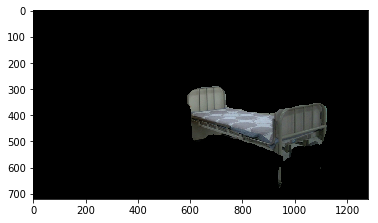

In [15]:
VISUALIZE = False
T_bc = viewpoint.get_tf(VIEW_MOVED_EXT)
# capture image of full view
if CONNECT_CAM:
    rdict = stream_capture_image(
        ImageType.FullView, obj_type="full_view", host=CAM_HOST,
        crob=crob)
    
else:
    rdict, VIEW_MOVED_EXT = load_rdict("full_view")
    T_bc = viewpoint.get_tf(VIEW_MOVED_EXT)
    gscene.show_pose(VIEW_MOVED_EXT)
    
cdp = rdict2cdp(rdict)

if ENABLE_DETECT:
    # Output of inference(mask for detected table)
    mask_out = sd.inference(color_img=cdp.color)
    cv2.imwrite(os.path.join(SAVE_DIR, "mask_bed_re.png"), mask_out)
else:
    mask_out = cv2.imread(os.path.join(SAVE_DIR, "mask_bed_re.png"))[:,:,0]
    
if np.any(mask_out):
    cdp_masked = apply_mask(cdp, mask_out)
    plt.imshow(cdp_masked.color[:,:,[2,1,0]])

    icp_bed.clear()
    pcd = icp_bed.add_image(cdp_masked, Tc=T_bc)
    T_bs_pre = gscene.NAME_DICT["bed_vis"].get_tf(VIEW_MOVED_EXT)
    T_bo_bed, fitness = icp_bed.compute_ICP(To=T_bs_pre, thres=0.12, visualize=VISUALIZE)
#         # front_ICP
#         T_bo_bed, fitness = icp_bed.compute_front_ICP(T_bc, To=T_bs_pre, thres=0.12, visualize=VISUALIZE)
    # adjust
    T_bo_bed[2]=0
    T_bo_bed[:3, :3]=Rot_axis(3, Rot2axis(T_bo_bed[:3, :3], 3))
    move_bed(gscene, T_bo_bed[:3,3], Rot2rpy(T_bo_bed[:3,:3]))

    if VISUALIZE: # show final result
        icp_bed.draw(gscene.NAME_DICT["bed_vis"].get_tf(VIEW_MOVED_EXT))
else:
    raise(RuntimeError("bed not detected"))

#### 1.2.3  detect and add closet

In [16]:
VISUALIZE = False
if ENABLE_O3D:
    icp_closet = MultiICP(model=MODEL_DIR + '/top_table/top_table.STL', 
                       Toff=SE3([[1,0,0],[0,0,1],[0,-1,0]], [0.3,0,0.2725]))
    
    if CONNECT_CAM:
        rdict = stream_capture_image(ImageType.FirstView, obj_type="top_table", host=CAM_HOST,
                                     crob=crob)
    else:
        rdict, VIEW_MOVED_EXT = load_rdict("top_table")

    T_bc = viewpoint.get_tf(VIEW_MOVED_EXT)
    
    cdp = rdict2cdp(rdict)
    pcd_closet = cdp2pcd(cdp, T_bc)
    
    
    pcd_masked = mask_boxes(pcd_closet, 
                        boxes=[gscene.NAME_DICT["bed_{}_space".format(CLOSET_LOCATION.lower())]], 
                        Q=VIEW_MOVED_EXT, inside=True, 
                        merge_rule=np.all, link_ref="base_link")
    pcd_masked = mask_boxes(pcd_masked, 
                        boxes=[gscene.NAME_DICT["bed_box"], 
                               gscene.NAME_DICT["bed_wall"], 
                               gscene.NAME_DICT["floor_box"]], 
                        Q=VIEW_MOVED_EXT, inside=False, 
                        merge_rule=np.all, link_ref="base_link")
    pcd_masked, ind = pcd_masked.remove_radius_outlier(nb_points=20, radius=0.06)
    icp_closet.add_pointcloud(pcd_masked, T_bc, ratio=0.5)
    
    Tbs = bed_vis.get_tf(VIEW_MOVED_EXT)
    initial_guess = icp_closet.get_initial_by_median(
        Tbs[:3, :3], 
        np.matmul(T_bc[:3,:3], (0,0,0.3))-(0,0,1))
    with gtimer.block("ICP"):
        T_bo, fitness = icp_closet.compute_front_ICP(T_bc, initial_guess, thres=0.05, visualize=VISUALIZE)
    
#     # front_cut_ICP
#     T_bo, fitness = icp_closet.compute_front_cut_ICP("closet",
#                            initial_guess, thres=0.05, visualize=VISUALIZE)
    
    #adjust
    T_bo[2]=0
    T_bo[:3, :3]=Rot_axis(3, Rot2axis(T_bo[:3, :3], 3))
#     gscene.show_point_cloud(pcd_closet.points, "allpoints", color=(0,0,0,0.5), dims=(0.01,0.01,0.01), sample_to=500)
#     gscene.show_point_cloud(pcd_masked.points, "masked", color=(1,0,0,1), dims=(0.02,0.02,0.02))
else:
    T_bo = T_xyzrpy((np.matmul(Rot_rpy(bed_rpy), (-0.75,-1.5,0))+bed_center, 
                     bed_rpy))
    
closet_leftup, closet_rightup, closet_down = add_closet(
    gscene, closet_center=T_bo[:3,3], closet_rpy=Rot2rpy(T_bo[:3,:3]), 
    COLOR_CLOSET_COL=(0,1,0,0.3))

add_backwall(gscene)

Connect: Server IP (192.168.0.3)
Apply point-to-point ICP
registration::RegistrationResult with fitness=6.536582e-01, inlier_rmse=1.442485e-02, and correspondence_set size of 10167
Access transformation to get result.
Transformation is:
[[-9.99786274e-01  1.90810020e-03  2.05847095e-02  5.74686857e+00]
 [ 2.06427330e-02  3.83218716e-02  9.99052189e-01  7.19164736e-01]
 [ 1.11744709e-03  9.99263626e-01 -3.83530697e-02  1.41928712e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [17]:
if CONNECT_MOBILE and CONNECT_CAM:
    save_pickle("gargs.pkl".format(get_now()), 
                gscene.get_gtem_args())
else:
    filelist = sorted([fname for fname in os.listdir(os.getcwd()) if fname.startswith("gargs_")])
    gtem_args = load_pickle("gargs.pkl")      
    for garg in gtem_args:
        if garg['parent'] == None and garg['link_name']=="base_link":
            if garg["name"] in gscene.NAME_DICT:
                gscene.NAME_DICT[garg["name"]].set_offset_tf(center=garg["center"], orientation_mat=Rot_rpy(garg["rpy"]))
gscene.update_markers_all() 

In [18]:
pole_pt_list = kmm.remove_poles_by_box(gscene, gscene.NAME_DICT["bed_box"], 
                    pole_pt_list, VIEW_POSE_EXT)
pole_pt_list = kmm.remove_poles_by_box(gscene, gscene.NAME_DICT["closet_box"], 
                    pole_pt_list, VIEW_POSE_EXT)
pole_pt_list = kmm.remove_poles_by_box(gscene, gscene.NAME_DICT["room_box"], 
                    pole_pt_list, VIEW_POSE_EXT, inside=False)
pole_list = kmm.add_pixel_poles("obs_pt", gscene, pole_pt_list, pole_res)
gcheck.ignore_always = pole_list

In [19]:
# # Extract triangle mesh fron rgbd image
# # If T_bc is not given, then the mesh coordinate is camera coordinate
# mesh = extract_mesh(cdp, T_bc=T_bc_new, visualize=False)

# remove_boxes = [gscene.NAME_DICT["bed_box"],
#                 gscene.NAME_DICT["closet_box"],
#                 gscene.NAME_DICT["floor_box"]
#                ]
# mesh_cut, mesh_colors = \
#     mask_boxes_mesh(mesh, remove_boxes, 
#                     VIEW_POSE_EXT, inside=False, 
#                     merge_rule=np.all, link_ref="base_link")
# gscene.create_safe(GEOTYPE.MESH, "env_mesh", link_name="base_link",
#                   dims=(1,1,1), center=(0,0,0), rpy=(0,0,0),
#                   color=(1,1,1,1), fixed=True, collision=True,
#                   vertices=mesh_cut.vertices, triangles=mesh_cut.triangles,
#                   colors=mesh_colors)

In [20]:
from pkg.ui.ui_broker import *

# start UI
ui_broker = UIBroker.instance()
ui_broker.initialize(ppline, s_builder)
ui_broker.start_server()

ui_broker.set_tables()

Dash is running on http://0.0.0.0:8050/

 * Serving Flask app "pkg.ui.dash_launcher" (lazy loading)



## 2. Closet cleaning

### 2.0. Prepare functions

In [21]:
from pkg.planning.constraint.constraint_common import *
from pkg.planning.constraint.constraint_actor import *
from pkg.planning.constraint.constraint_subject import *
from pkg.utils.code_scraps import get_look_motion

 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


In [22]:
# mplan.reset_log(flag_log=True)
Q_CUR = VIEW_MOVED_EXT
HOME_POSE_SWEEP = np.copy(Q_CUR)
# HOME_POSE_SWEEP[6:] = 0
crob.home_pose = HOME_POSE_SWEEP
crob.home_dict = list2dict(crob.home_pose, 
                           gscene.joint_names)
floor_ws = gscene.NAME_DICT["floor_ws"]    

brush_face = change_tool(
    pscene, kmb, ToolDir.down, TOOL_OFFSET, TIP_LINK, 
    TOOL_NAME, SweepFramer, clearance=CLEARANCE)

Tool Down


In [23]:
adjust_count_list = []
def look_closet_get_offset(gxter, crob, mplan, robot_name, Qref):
    for _ in range(5):
        traj, succ = get_look_motion(mplan, robot_name, Qref, 
                                     target_point=gscene.NAME_DICT["closet_leftup"],
                                     com_link=pscene.robot_chain_dict[robot_name]['link_names'][-1],
                                     view_dir=[0,0,1],timeout=1)
        traj_rev = np.array(list(reversed(traj)))

    if not succ:
        look_closet_get_offset.Qref_fail = Qref
        raise(RuntimeError("Get Look Motion Fail"))

    Qref[6:] = traj[-1][6:]
    gscene.show_pose(Qref)
    if CONNECT_INDY:
        with indy: # move to look
            crob.move_joint_traj(traj, one_by_one=True)

    time.sleep(1)

    icp_closet = MultiICP(model=MODEL_DIR + '/top_table/top_table.STL', 
                       Toff=SE3([[1,0,0],[0,0,1],[0,-1,0]], [0.3,0,0.2725]))

    adjust_count_list.append(1)
    if CONNECT_CAM:
        rdict = stream_capture_image(ImageType.FirstView, 
                                     obj_type="closet_{}".format(len(adjust_count_list)), 
                                     host=CAM_HOST, crob=crob)
    else:
        rdict, Qref = load_rdict("closet_{}".format(len(adjust_count_list)))
        gscene.show_pose(Qref)

    T_bc, T_bs_closet = viewpoint.get_tf(Qref), gscene.NAME_DICT["closet_vis"].get_tf(Qref)

    cdp = rdict2cdp(rdict)
    pcd_closet = cdp2pcd(cdp, T_bc)

    with gtimer.block("masking"):
        pcd_masked = mask_boxes(pcd_closet, 
                            boxes=[gscene.NAME_DICT["closet_box"]], 
                            Q=Qref, inside=True, 
                            merge_rule=np.all, link_ref="base_link")
        pcd_masked = mask_boxes(pcd_masked, 
                            boxes=[gscene.NAME_DICT["bed_box"], 
                                   gscene.NAME_DICT["bed_wall"], 
                                   gscene.NAME_DICT["floor_box"],
                                   gscene.NAME_DICT["back_wall"]], 
                            Q=Qref, inside=False, 
                            merge_rule=np.all, link_ref="base_link")

    with gtimer.block("adding"):
        icp_closet.add_pointcloud(pcd_masked, T_bc)

    initial_guess = gscene.NAME_DICT["closet_vis"].get_tf(Qref)
    with gtimer.block("compute_front_ICP"):
        # front_ICP
        T_bo_close, fitness = icp_closet.compute_front_ICP(
            T_bc, initial_guess, thres=0.05, visualize=VISUALIZE)

    # calculate transform based on obtained points
    pcd_center_prev = pcd_masked.get_center()

    T_bo_p = SE3(T_bo_close[:3,:3], pcd_center_prev)
    T_pooc = np.matmul(SE3_inv(T_bo_p), T_bo_close)
    T_bo_p[:3,:3] = Rot_axis(3, Rot2axis(T_bo_close[:3,:3], 3))
    T_bo_c_fix = np.matmul(T_bo_p, T_pooc)
    T_bo_c_fix[2,3] = 0

    # get Twoff from redetection
    Tbo0, Tbo1 = T_bs_closet, T_bo_c_fix
    Tbw0 = gscene.get_tf(gxter.mobile_link, Qref)
    Tow1 = np.matmul(SE3_inv(Tbo1), Tbw0)
    Tbw1 = np.matmul(Tbo0, Tow1)

    Qcur = np.copy(Qref)
    Qcur[:2] = Tbw1[:2,3]
    Qcur[2] = Rot2axis(Tbw1[:3,:3], 3)

    Tow0 = np.matmul(SE3_inv(Tbo0), Tbw0)
    Tbw1tar = np.matmul(Tbo1, Tow0)
    Qtar = np.copy(Qref)
    Qtar[:2] = Tbw1tar[:2,3]
    Qtar[2] = Rot2axis(Tbw1tar[:3,:3], 3)
    return Qcur, Qtar

### 2.1. Greedily execute closet cleaning

In [24]:
VISUALIZE = True

In [25]:
VEL_LEVEL = 3

if CONNECT_INDY:
    with indy:
        vel_level_bak = indy.get_joint_vel_level()
        print("vel_level_bak: {}".format(vel_level_bak))

    with indy:
        indy.set_joint_vel_level(VEL_LEVEL)
        
    indy.collision_policy = POLICY_NO_COLLISION_DETECTION
swp_fin_list = []

Qcur = VIEW_MOVED_EXT
mode_switcher=ModeSwitcherKMB(pscene, push_dist=0.0)

Connect: Server IP (192.168.0.3)
vel_level_bak: 5
Connect: Server IP (192.168.0.3)


In [26]:
gscene.add_virtual_guardrail(
    closet_leftup, HEIGHT=0.2, margin=0.1)
gxter = GreedyExecuter(ppline, brush_face, TOOL_DIM, Qcur)
gxter.set_test_kwargs(multiprocess=PLANNING_MULTIPROC,
                           timeout=0.3, timeout_loop=5.0)
gxter.get_division_dict(closet_leftup, "up", "Z", None)
gxter.init_base_divs(Qcur)
snode_schedule_list_lu, Qcur, covereds = gxter.greedy_execute(Qcur, 1, mode_switcher, look_closet_get_offset)
gxter.test_clear()

Send to mobile: [ 1.746  2.768 -0.25   0.968]
             -> [ 4.207  1.618 -0.012  1.     0.   ]
Distance=2.75942491571 ([ 2.462 -1.15   0.482])
goal reach: 1 -> 0 (1636102388.61)
goal reach: 0 -> 1 (1636102402.58)
goal reach signal edge up
End up at=[ 4.244  1.644 -0.007] (0.0479 / 0.0479)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Move finished!
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.903256e-01, inlier_rmse=1.621456e-02, and correspondence_set size of 11194
Access transformation to get result.
Transformation is:
[[-9.99983723e-01 -5.70852880e-03  1.15153571e-04  5.80933733e+00]
 [-7.06948086e-07  2.02918823e-02  9.99794122e-01  6.55583955e-01]
 [-5.70969023e-03  9.99777801e-01 -2.02915560e-02 -1.57274166e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[PLAN] Current posit

======================= terminated 24: max iteration time reached (5/5.0 s) ===============================
======================= terminated 3: max iteration time reached (5/5.0 s) ===============================
======================= terminated 20: max iteration time reached (5/5.0 s) ===============================
======================= terminated 4: max iteration time reached (5/5.0 s) ===============================
======================= terminated 29: max iteration time reached (5/5.0 s) ===============================
======================= terminated 33: max iteration time reached (5/5.0 s) ===============================
======================= terminated 5: max iteration time reached (5/5.0 s) ===============================
======================= terminated 30: max iteration time reached (5/5.0 s) ===============================
======================= terminated 34: max iteration time reached (5/5.0 s) ===============================
======================= termina

======================= terminated 4: required answers acquired ===============================
======================= terminated 34: required answers acquired from other agent ===============================
======================= terminated 22: required answers acquired from other agent ===============================
======================= terminated 35: required answers acquired from other agent ===============================
Goal reached
======================= terminated 3: required answers acquired ===============================
======================= terminated 23: required answers acquired from other agent ===============================
======================= terminated 24: required answers acquired from other agent ===============================
Goal reached
======================= terminated 6: required answers acquired ===============================
Goal reached
======================= terminated 2: required answers acquired ===============================
Goal re

======================= terminated 4: max iteration time reached (5/5.0 s) ===============================
======================= terminated 31: max iteration time reached (5/5.0 s) ===============================
======================= terminated 33: max iteration time reached (5/5.0 s) ===============================
======================= terminated 32: max iteration time reached (5/5.0 s) ===============================
======================= terminated 11: max iteration time reached (5/5.0 s) ===============================
======================= terminated 6: max iteration time reached (5/5.0 s) ===============================
======================= terminated 35: max iteration time reached (5/5.0 s) ===============================
======================= terminated 5: max iteration time reached (5/5.0 s) ===============================
======================= terminated 14: max iteration time reached (5/5.0 s) ===============================
======================= termina

======================= terminated 20: max iteration time reached (5/5.0 s) ===============================
======================= terminated 8: max iteration time reached (5/5.0 s) ===============================
======================= terminated 16: max iteration time reached (5/5.0 s) ===============================
======================= terminated 3: max iteration time reached (5/5.0 s) ===============================
======================= terminated 22: max iteration time reached (5/5.0 s) ===============================
======================= terminated 23: max iteration time reached (5/5.0 s) ===============================
======================= terminated 24: max iteration time reached (5/5.0 s) ===============================
======================= terminated 2: max iteration time reached (5/5.0 s) ===============================
======================= terminated 9: max iteration time reached (5/5.0 s) ===============================
Goal reached
Connect: Server IP 

Goal reached
======================= terminated 7: required answers acquired ===============================
======================= terminated 35: required answers acquired from other agent ===============================
======================= terminated 28: required answers acquired from other agent ===============================
======================= terminated 13: required answers acquired from other agent ===============================
======================= terminated 0: required answers acquired from other agent ===============================
Goal reached
======================= terminated 15: required answers acquired ===============================
Goal reached
======================= terminated 14: required answers acquired ===============================
Goal reached
======================= terminated 18: required answers acquired ===============================
======================= terminated 16: required answers acquired from other agent ========================

======================= terminated 30: required answers acquired ===============================
Goal reached
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Move finished!
Connect: Server IP (192.168.0.3)
binder: brush_face
rname: indy1
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Move finished!
Connect: Server IP (192.168.0.3)
binder: brush_face
rname: indy1
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Move finished!
Connect: Server IP (192.168.0.3)
binder: brush_face
rname: indy1
Connect: Server IP (192.168.0.3)


In [27]:
brush_face = change_tool(pscene, kmb, ToolDir.up, TOOL_OFFSET, TIP_LINK, TOOL_NAME, SweepFramer, clearance=CLEARANCE)
gxter_u = GreedyExecuter(ppline, brush_face, TOOL_DIM, Qcur, drift=gxter.drift)
gxter_u.set_test_kwargs(multiprocess=PLANNING_MULTIPROC,
                           timeout=0.3, timeout_loop=5.0)
gxter_u.get_division_dict(closet_leftup, "front", "Z", None)
gxter_u.remove_covered(covereds)
gxter_u.init_base_divs(Qcur)
snode_schedule_list_lf, Qcur, covereds = gxter_u.greedy_execute(Qcur, 1, mode_switcher, look_closet_get_offset)
brush_face = change_tool(pscene, kmb, ToolDir.down, TOOL_OFFSET, TIP_LINK, TOOL_NAME, SweepFramer, clearance=CLEARANCE)
gxter_u.test_clear()
gscene.clear_virtuals()

Tool UP
Send to mobile: [4.467 1.349 0.007 1.   ]
             -> [ 4.407  1.348 -0.011  1.     1.   ]
Distance=0.070708393087 ([-0.06  -0.001 -0.037])
goal reach: 1 -> 0 (1636102507.71)
goal reach: 0 -> 1 (1636102509.92)
goal reach signal edge up
End up at=[ 4.404  1.35  -0.035] (0.0125 / 0.0125)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Move finished!
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.369419e-01, inlier_rmse=1.407814e-02, and correspondence_set size of 11162
Access transformation to get result.
Transformation is:
[[-9.99620227e-01 -1.57075939e-02 -2.26433234e-02  5.88586376e+00]
 [-2.32997235e-02  4.29470967e-02  9.98805645e-01  6.86603777e-01]
 [-1.47163685e-02  9.98953862e-01 -4.32967691e-02  5.48920457e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[PLAN] Current 

======================= terminated 12: max iteration time reached (5/5.0 s) ===============================
======================= terminated 30: max iteration time reached (5/5.0 s) ===============================
======================= terminated 11: max iteration time reached (5/5.0 s) ===============================
======================= terminated 8: max iteration time reached (5/5.0 s) ===============================
======================= terminated 10: max iteration time reached (5/5.0 s) ===============================
======================= terminated 28: max iteration time reached (5/5.0 s) ===============================
======================= terminated 13: max iteration time reached (5/5.0 s) ===============================
======================= terminated 15: max iteration time reached (5/5.0 s) ===============================
======================= terminated 19: max iteration time reached (5/5.0 s) ===============================
======================= termi

======================= terminated 34: max iteration time reached (5/5.0 s) ===============================
======================= terminated 15: max iteration time reached (5/5.0 s) ===============================
======================= terminated 30: max iteration time reached (5/5.0 s) ===============================
======================= terminated 1: max iteration time reached (5/5.0 s) ===============================
======================= terminated 20: max iteration time reached (5/5.0 s) ===============================
======================= terminated 3: max iteration time reached (5/5.0 s) ===============================
======================= terminated 31: max iteration time reached (5/5.0 s) ===============================
======================= terminated 4: max iteration time reached (5/5.0 s) ===============================
======================= terminated 23: max iteration time reached (5/5.0 s) ===============================
======================= termina

======================= terminated 11: max iteration time reached (5/5.0 s) ===============================
======================= terminated 18: max iteration time reached (5/5.0 s) ===============================
Send to mobile: [ 4.288  1.354 -0.021  1.   ]
             -> [ 4.172e+00  1.351e+00 -1.000e-03  1.000e+00  1.000e+00]
Distance=0.12332493802 ([-0.116 -0.002  0.041])
goal reach: 1 -> 0 (1636102549.68)
goal reach: 0 -> 1 (1636102552.76)
goal reach signal edge up
End up at=[4.16  1.35  0.018] (0.0231 / 0.0231)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Move finished!
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.522831e-01, inlier_rmse=1.422183e-02, and correspondence_set size of 9548
Access transformation to get result.
Transformation is:
[[-0.99975925 -0.01786589  0.01273985  5.85602287]
 [ 0.0

======================= terminated 0: required answers acquired ===============================
======================= terminated 23: required answers acquired from other agent ===============================
Goal reached
======================= terminated 7: required answers acquired ===============================
Goal reached
======================= terminated 3: required answers acquired ===============================
Goal reached
======================= terminated 5: required answers acquired ===============================
======================= terminated 24: required answers acquired from other agent ===============================
======================= terminated 26: required answers acquired from other agent ===============================
Goal reached
Goal reached
Goal reached
======================= terminated 17: required answers acquired ===============================
======================= terminated 8: required answers acquired ===============================
===

In [28]:
gscene.add_virtual_guardrail(
    closet_rightup, HEIGHT=0.2, margin=0.03)
gxter = GreedyExecuter(ppline, brush_face, TOOL_DIM, Qcur, drift=gxter_u.drift)
gxter.set_test_kwargs(multiprocess=PLANNING_MULTIPROC,
                           timeout=0.3, timeout_loop=5.0)

gxter.get_division_dict(closet_rightup, "up", "Z", None)
gxter.init_base_divs(Qcur)
snode_schedule_list_ru, Qcur, covereds = gxter.greedy_execute(Qcur, 1, mode_switcher, look_closet_get_offset)
gxter.test_clear()
gscene.clear_virtuals()

Send to mobile: [4.293e+00 1.213e+00 2.000e-03 1.000e+00]
             -> [ 4.47   1.162 -0.015  1.     0.   ]
Distance=0.187374185421 ([ 0.177 -0.052 -0.032])
goal reach: 1 -> 0 (1636099255.87)
goal reach: 0 -> 1 (1636099260.28)
goal reach signal edge up
End up at=[4.469 1.146 0.007] (0.0395 / 0.0395)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Move finished!
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.762688e-01, inlier_rmse=1.516714e-02, and correspondence_set size of 16959
Access transformation to get result.
Transformation is:
[[-0.99531796 -0.03309724  0.09081122  5.88745551]
 [ 0.08949578  0.03926983  0.99521271  0.71196722]
 [-0.03650493  0.99868036 -0.0361239   0.04447441]
 [ 0.          0.          0.          1.        ]]
[PLAN] Line idc [1]
[PLAN] Try idc (1,)
terminate_on_first is deprecated. 

======================= terminated 21: max iteration time reached (5/5.0 s) ===============================
======================= terminated 31: max iteration time reached (5/5.0 s) ===============================
======================= terminated 28: max iteration time reached (5/5.0 s) ===============================
======================= terminated 22: max iteration time reached (5/5.0 s) ===============================
======================= terminated 15: max iteration time reached (5/5.0 s) ===============================
======================= terminated 18: max iteration time reached (5/5.0 s) ===============================
======================= terminated 34: max iteration time reached (5/5.0 s) ===============================
======================= terminated 17: max iteration time reached (5/5.0 s) ===============================
======================= terminated 12: max iteration time reached (5/5.0 s) ===============================
======================= term

======================= terminated 6: max iteration time reached (5/5.0 s) ===============================
======================= terminated 13: max iteration time reached (5/5.0 s) ===============================
======================= terminated 11: max iteration time reached (5/5.0 s) ===============================
======================= terminated 7: max iteration time reached (5/5.0 s) ===============================
======================= terminated 22: max iteration time reached (5/5.0 s) ===============================
======================= terminated 33: max iteration time reached (5/5.0 s) ===============================
======================= terminated 9: max iteration time reached (5/5.0 s) ===============================
======================= terminated 1: max iteration time reached (5/5.0 s) ===============================
======================= terminated 35: max iteration time reached (5/5.0 s) ===============================
======================= terminat

Goal reached
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Move finished!
Connect: Server IP (192.168.0.3)
binder: brush_face
rname: indy1
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Move finished!
Connect: Server IP (192.168.0.3)
binder: brush_face
rname: indy1
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Move finished!
Connect: Server IP (192.168.0.3)
binder: brush_face
rname: indy1
Connect: Server IP (192.168.0.3)


In [29]:
gscene.add_virtual_guardrail(
    closet_down, HEIGHT=0.2, margin=0.15)
gxter = GreedyExecuter(ppline, brush_face, TOOL_DIM, Qcur, drift=gxter.drift)
gxter.set_test_kwargs(multiprocess=PLANNING_MULTIPROC,
                           timeout=0.3, timeout_loop=5.0)

gxter.get_division_dict(closet_down, "down", "Z", None)
gxter.init_base_divs(Qcur)
snode_schedule_list_d, Qcur, covereds = gxter.greedy_execute(Qcur, -1, mode_switcher, look_closet_get_offset)
gxter.test_clear()
gscene.clear_virtuals()

Send to mobile: [ 4.62   1.165 -0.021  1.   ]
             -> [ 4.24   1.164 -0.015  1.     0.   ]
Distance=0.379977346788 ([-0.38  -0.001  0.012])
goal reach: 1 -> 0 (1636099348.66)
goal reach: 0 -> 1 (1636099357.26)
goal reach signal edge up
End up at=[ 4.234  1.149 -0.039] (0.0182 / 0.0182)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Move finished!
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.886483e-01, inlier_rmse=1.406649e-02, and correspondence_set size of 12886
Access transformation to get result.
Transformation is:
[[-0.99846362 -0.01797443  0.05241442  5.89140174]
 [ 0.05172156  0.03705922  0.99797367  0.78209404]
 [-0.01988044  0.99915141 -0.03607262  0.00935319]
 [ 0.          0.          0.          1.        ]]
[PLAN] Line idc [0, 2, 4]
[PLAN] Try idc (0, 2, 4)
terminate_on_first is deprecated

======================= terminated 29: max iteration time reached (5/5.0 s) ===============================
======================= terminated 21: max iteration time reached (5/5.0 s) ===============================
======================= terminated 30: max iteration time reached (5/5.0 s) ===============================
======================= terminated 19: max iteration time reached (5/5.0 s) ===============================
======================= terminated 4: max iteration time reached (5/5.0 s) ===============================
======================= terminated 27: max iteration time reached (5/5.0 s) ===============================
======================= terminated 20: max iteration time reached (5/5.0 s) ===============================
======================= terminated 10: max iteration time reached (5/5.0 s) ===============================
======================= terminated 35: max iteration time reached (5/5.0 s) ===============================
======================= termi

======================= terminated 35: max iteration time reached (5/5.0 s) ===============================
======================= terminated 11: max iteration time reached (5/5.0 s) ===============================
======================= terminated 12: max iteration time reached (5/5.0 s) ===============================
======================= terminated 16: max iteration time reached (5/5.0 s) ===============================
======================= terminated 32: max iteration time reached (5/5.0 s) ===============================
======================= terminated 34: max iteration time reached (5/5.0 s) ===============================
======================= terminated 17: max iteration time reached (5/5.0 s) ===============================
======================= terminated 4: max iteration time reached (5/5.0 s) ===============================
======================= terminated 2: max iteration time reached (5/5.0 s) ===============================
======================= termin

======================= terminated 9: required answers acquired ===============================
======================= terminated 18: required answers acquired from other agent ===============================
======================= terminated 22: required answers acquired from other agent ===============================
======================= terminated 35: required answers acquired from other agent ===============================
======================= terminated 14: required answers acquired from other agent ===============================
======================= terminated 5: required answers acquired from other agent ===============================
======================= terminated 21: required answers acquired from other agent ===============================
======================= terminated 26: required answers acquired from other agent ===============================
======================= terminated 24: required answers acquired from other agent =========================

======================= terminated 2: required answers acquired ===============================
Goal reached
======================= terminated 29: required answers acquired ===============================
Goal reached
======================= terminated 1: required answers acquired ===============================
Goal reached
======================= terminated 12: required answers acquired ===============================
Goal reached
======================= terminated 30: required answers acquired ===============================
Goal reached
======================= terminated 8: required answers acquired ===============================
======================= terminated 31: required answers acquired from other agent ===============================
Goal reached
======================= terminated 15: required answers acquired ===============================
Goal reached
======================= terminated 13: required answers acquired ===============================
[PLAN] Try idc (4,)
te

======================= terminated 17: max iteration time reached (5/5.0 s) ===============================
======================= terminated 21: max iteration time reached (5/5.0 s) ===============================
======================= terminated 26: max iteration time reached (5/5.0 s) ===============================
======================= terminated 4: max iteration time reached (5/5.0 s) ===============================
======================= terminated 25: max iteration time reached (5/5.0 s) ===============================
======================= terminated 24: max iteration time reached (5/5.0 s) ===============================
======================= terminated 9: max iteration time reached (5/5.0 s) ===============================
======================= terminated 8: max iteration time reached (5/5.0 s) ===============================
======================= terminated 10: max iteration time reached (5/5.0 s) ===============================
======================= termina

======================= terminated 12: required answers acquired from other agent ===============================
======================= terminated 27: required answers acquired from other agent ===============================
======================= terminated 24: required answers acquired from other agent ===============================
Goal reached
======================= terminated 4: required answers acquired ===============================
Goal reached
Goal reached
======================= terminated 13: required answers acquired from other agent ===============================
======================= terminated 19: required answers acquired ===============================
======================= terminated 20: required answers acquired ===============================
======================= terminated 29: required answers acquired from other agent ===============================
======================= terminated 33: required answers acquired from other agent ===================

======================= terminated 35: max iteration time reached (5/5.0 s) ===============================
======================= terminated 22: max iteration time reached (5/5.0 s) ===============================
Goal reached
======================= terminated 30: max iteration time reached (5/5.0 s) ===============================
======================= terminated 7: max iteration time reached (5/5.0 s) ===============================
Goal reached
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Move finished!
Connect: Server IP (192.168.0.3)
binder: brush_face
rname: indy1
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Move finished!
Connect: Server IP (192.168.0.3)
binder: brush_face
rname: indy1
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Move finished!
Conne

IndexError: tuple index out of range

## 3. Bed cleaning

In [26]:
brush_face = change_tool(pscene, kmb, ToolDir.down, TOOL_OFFSET, TIP_LINK, TOOL_NAME, SweepFramer, clearance=CLEARANCE)

BED_OFFSET = 0.2
brush_face = pscene.create_binder(bname=TOOL_NAME, gname=TOOL_NAME, _type=SweepFramer, 
                                  point=(0,0,-gscene.NAME_DICT['brush_face'].dims[2]/2-CLEARANCE-BED_OFFSET), 
                                  rpy=(0,0,0))

T_e_brush = brush_face.get_tf_handle(crob.home_dict, from_link=TIP_LINK)
T_brush_e = SE3_inv(T_e_brush)
EE_HEIGHT = round(bed_mat.get_tf(HOME_DICT)[2,3] + bed_mat.dims[2]/2, 5) \
                + T_brush_e[2, 3] - INDY_BASE_OFFSET[2]

Tool Down


In [27]:
gxter = GreedyExecuter(ppline, brush_face, TOOL_DIM, Qcur, 
                       drift=None)
#                        drift=gxter.drift)
gxter.set_test_kwargs(multiprocess=PLANNING_MULTIPROC,
                           timeout=0.5, timeout_loop=5.0)

gxter.get_division_dict(bed_mat, "front", "X", EE_HEIGHT, xout_cut=True)
gxter.init_base_divs(Qcur)

snode_schedule_list_d, Qcur, covereds = gxter.greedy_execute(Qcur, 1, mode_switcher, look_closet_get_offset)
gxter.test_clear()

('Height Reference: ', 0.7020000109672546)
[INFO] Approach through: [ 4.21485085  1.46724745 -1.56942786] -> [ 4.23082401  1.22619738 -1.56942786]
Send to mobile: [ 1.871  2.873 -0.273  0.962]
             -> [ 4.215  1.467 -0.707  0.708  0.   ]
Distance=2.91660330678 ([ 2.344 -1.406 -1.017])
goal reach: 1 -> 0 (1636103271.2)
goal reach: 0 -> 1 (1636103288.73)
goal reach signal edge up
End up at=[ 4.225  1.48  -1.585] (0.023 / 0.023)
Send to mobile: [ 4.225  1.48   0.712 -0.702]
             -> [ 4.231  1.226 -0.707  0.708  0.   ]
Distance=3.05245663189 ([ 2.36  -1.647 -1.017])
goal reach: 1 -> 0 (1636103289.87)
goal reach: 0 -> 1 (1636103296.04)
goal reach signal edge up
End up at=[ 4.225  1.216 -1.591] (0.0241 / 0.0241)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Move finished!
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Apply point-to-point ICP
registration::RegistrationResu

======================= terminated 31: required answers acquired from other agent ===============================
======================= terminated 33: required answers acquired from other agent ===============================
======================= terminated 9: required answers acquired from other agent ===============================
======================= terminated 6: required answers acquired from other agent ===============================
======================= terminated 25: required answers acquired from other agent ===============================
======================= terminated 10: required answers acquired from other agent ===============================
======================= terminated 32: required answers acquired from other agent ===============================
======================= terminated 7: required answers acquired from other agent ===============================
======================= terminated 35: required answers acquired from other agent =========

======================= terminated 19: required answers acquired from other agent ===============================
======================= terminated 17: required answers acquired from other agent ===============================
======================= terminated 15: required answers acquired from other agent ===============================
======================= terminated 18: required answers acquired from other agent ===============================
======================= terminated 24: required answers acquired from other agent ===============================
======================= terminated 27: required answers acquired from other agent ===============================
Goal reached
======================= terminated 0: required answers acquired ===============================
Goal reached
Goal reached
======================= terminated 1: required answers acquired ===============================
======================= terminated 4: required answers acquired =====================

======================= terminated 29: required answers acquired from other agent ===============================
======================= terminated 32: required answers acquired from other agent ===============================
Goal reached
======================= terminated 16: required answers acquired ===============================
======================= terminated 30: required answers acquired from other agent ===============================
======================= terminated 33: required answers acquired from other agent ===============================
======================= terminated 3: required answers acquired from other agent ===============================
======================= terminated 34: required answers acquired from other agent ===============================
======================= terminated 35: required answers acquired from other agent ===============================
[PLAN] Line idc [16, 15]
[PLAN] Try idc (16, 15)
terminate_on_first is deprecated. Use max_so

Goal reached
======================= terminated 19: required answers acquired ===============================
Goal reached
======================= terminated 21: required answers acquired ===============================
Goal reached
======================= terminated 17: required answers acquired ===============================
======================= terminated 12: required answers acquired from other agent ===============================
======================= terminated 22: required answers acquired from other agent ===============================
======================= terminated 6: required answers acquired from other agent ===============================
======================= terminated 2: required answers acquired from other agent ===============================
Goal reached
======================= terminated 20: required answers acquired ===============================
Goal reached
======================= terminated 16: required answers acquired ============================

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.670319e-01, inlier_rmse=1.535880e-02, and correspondence_set size of 15700
Access transformation to get result.
Transformation is:
[[-0.99988179  0.00692615 -0.01372824  5.78800342]
 [-0.0134016   0.04518667  0.99888868  0.76133828]
 [ 0.00753878  0.99895455 -0.04508851 -0.02387061]
 [ 0.          0.          0.          1.        ]]
[PLAN] Current position is closer to other Tsm_key. Try switch ((1.006, -1.146, -0.66), (0.0, 0.0, 0.707, 0.707)) (1) -> ((-0.098, -1.146, -0.66), (0.0, 0.0, 0.707, 0.707)) (1)
[PLAN] Line idc [0]
[PLAN] Try idc (0,)
terminate_on_first is deprecated. Use max_solution_count=1
Use 36/36 agents
======================= terminated 28: max iteration time reached (5/5.0 s) ===============================
======================= terminated 6: max iteration time reached (5/5.0 s) ===============================
======================= terminated 3: max iteration time reached (5/5.0 s) ========

======================= terminated 26: max iteration time reached (5/5.0 s) ===============================
======================= terminated 1: max iteration time reached (5/5.0 s) ===============================
======================= terminated 11: max iteration time reached (5/5.0 s) ===============================
======================= terminated 29: max iteration time reached (5/5.0 s) ===============================
======================= terminated 34: max iteration time reached (5/5.0 s) ===============================
======================= terminated 23: max iteration time reached (5/5.0 s) ===============================
======================= terminated 20: max iteration time reached (5/5.0 s) ===============================
======================= terminated 35: max iteration time reached (5/5.0 s) ===============================
======================= terminated 2: max iteration time reached (5/5.0 s) ===============================
======================= termin

======================= terminated 25: max iteration time reached (5/5.0 s) ===============================
======================= terminated 19: max iteration time reached (5/5.0 s) ===============================
======================= terminated 34: max iteration time reached (5/5.0 s) ===============================
======================= terminated 15: max iteration time reached (5/5.0 s) ===============================
======================= terminated 20: max iteration time reached (5/5.0 s) ===============================
======================= terminated 31: max iteration time reached (5/5.0 s) ===============================
======================= terminated 26: max iteration time reached (5/5.0 s) ===============================
======================= terminated 12: max iteration time reached (5/5.0 s) ===============================
======================= terminated 22: max iteration time reached (5/5.0 s) ===============================
======================= term

======================= terminated 14: max iteration time reached (5/5.0 s) ===============================
======================= terminated 27: max iteration time reached (5/5.0 s) ===============================
======================= terminated 13: max iteration time reached (5/5.0 s) ===============================
======================= terminated 4: max iteration time reached (5/5.0 s) ===============================
======================= terminated 11: max iteration time reached (5/5.0 s) ===============================
======================= terminated 25: max iteration time reached (5/5.0 s) ===============================
======================= terminated 10: max iteration time reached (5/5.0 s) ===============================
======================= terminated 19: max iteration time reached (5/5.0 s) ===============================
======================= terminated 7: max iteration time reached (5/5.0 s) ===============================
======================= termin

======================= terminated 1: max iteration time reached (5/5.0 s) ===============================
======================= terminated 15: max iteration time reached (5/5.0 s) ===============================
======================= terminated 26: max iteration time reached (5/5.0 s) ===============================
======================= terminated 31: max iteration time reached (5/5.0 s) ===============================
======================= terminated 32: max iteration time reached (5/5.0 s) ===============================
======================= terminated 28: max iteration time reached (5/5.0 s) ===============================
======================= terminated 35: max iteration time reached (5/5.0 s) ===============================
======================= terminated 34: max iteration time reached (5/5.0 s) ===============================
======================= terminated 33: max iteration time reached (5/5.0 s) ===============================
[PLAN] Try idc (9,)
terminate

======================= terminated 32: max iteration time reached (5/5.0 s) ===============================
======================= terminated 17: max iteration time reached (5/5.0 s) ===============================
======================= terminated 35: max iteration time reached (5/5.0 s) ===============================
======================= terminated 24: max iteration time reached (5/5.0 s) ===============================
======================= terminated 33: max iteration time reached (5/5.0 s) ===============================
======================= terminated 4: max iteration time reached (5/5.0 s) ===============================
======================= terminated 6: max iteration time reached (5/5.0 s) ===============================
======================= terminated 20: max iteration time reached (5/5.0 s) ===============================
======================= terminated 27: max iteration time reached (5/5.0 s) ===============================
======================= termin

======================= terminated 19: required answers acquired from other agent ===============================
Goal reached
======================= terminated 24: required answers acquired from other agent ===============================
Goal reached
======================= terminated 6: required answers acquired ===============================
======================= terminated 9: required answers acquired ===============================
======================= terminated 21: required answers acquired from other agent ===============================
Goal reached
Goal reached
======================= terminated 2: required answers acquired ===============================
======================= terminated 3: required answers acquired ===============================
======================= terminated 30: required answers acquired from other agent ===============================
Goal reached
======================= terminated 25: required answers acquired from other agent =============

Goal reached
======================= terminated 20: required answers acquired ===============================
======================= terminated 29: required answers acquired from other agent ===============================
Goal reached
======================= terminated 0: required answers acquired from other agent ===============================
======================= terminated 14: required answers acquired ===============================
Goal reached
======================= terminated 17: required answers acquired ===============================
Goal reached
======================= terminated 18: required answers acquired ===============================
Goal reached
Goal reached
======================= terminated 16: required answers acquired ===============================
======================= terminated 22: required answers acquired ===============================
[PLAN] Line idc [11]
[PLAN] Try idc (11,)
terminate_on_first is deprecated. Use max_solution_count=1
Use 36/36 ag

======================= terminated 25: required answers acquired from other agent ===============================
======================= terminated 32: required answers acquired from other agent ===============================
======================= terminated 26: required answers acquired from other agent ===============================
Goal reached
======================= terminated 13: required answers acquired ===============================
======================= terminated 33: required answers acquired from other agent ===============================
======================= terminated 34: required answers acquired from other agent ===============================
======================= terminated 1: required answers acquired from other agent ===============================
======================= terminated 35: required answers acquired from other agent ===============================
Goal reached
======================= terminated 11: required answers acquired ===============

[PLAN] Current position is closer to other Tsm_key. Try switch ((1.006, -1.146, -0.66), (0.0, 0.0, 0.707, 0.707)) (3) -> ((-0.04, 1.293, -0.66), (0.0, 0.0, 0.707, -0.707)) (3)
[PLAN] Line idc [5]
[PLAN] Try idc (5,)
terminate_on_first is deprecated. Use max_solution_count=1
Use 36/36 agents
Goal reached
Goal reached
======================= terminated 5: required answers acquired ===============================
======================= terminated 18: required answers acquired from other agent ===============================
Goal reached
======================= terminated 4: required answers acquired ===============================
======================= terminated 19: required answers acquired from other agent ===============================
======================= terminated 22: required answers acquired from other agent ===============================
======================= terminated 32: required answers acquired from other agent ===============================
Goal reached
========

======================= terminated 28: required answers acquired from other agent ===============================
Goal reached
======================= terminated 10: required answers acquired ===============================
Goal reached
======================= terminated 12: required answers acquired ===============================
Goal reached
======================= terminated 14: required answers acquired ===============================
Goal reached
======================= terminated 11: required answers acquired ===============================
Goal reached
======================= terminated 17: required answers acquired ===============================
Goal reached
======================= terminated 15: required answers acquired ===============================
Goal reached
======================= terminated 20: required answers acquired ===============================
======================= terminated 30: required answers acquired from other agent ===============================
Go

======================= terminated 23: required answers acquired from other agent ===============================
======================= terminated 31: required answers acquired from other agent ===============================
Goal reached
======================= terminated 9: required answers acquired ===============================
======================= terminated 32: required answers acquired from other agent ===============================
======================= terminated 25: required answers acquired from other agent ===============================
======================= terminated 33: required answers acquired from other agent ===============================
======================= terminated 34: required answers acquired from other agent ===============================
======================= terminated 35: required answers acquired from other agent ===============================
Goal reached
======================= terminated 12: required answers acquired ===============

Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Move finished!
Connect: Server IP (192.168.0.3)
binder: brush_face
rname: indy1
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Move finished!
Connect: Server IP (192.168.0.3)
binder: brush_face
rname: indy1
Connect: Server IP (192.168.0.3)
Send to mobile: [ 4.915 -1.08   0.709  0.706]
             -> [ 4.647 -1.057  0.717  0.697  0.   ]
Distance=0.270825036365 ([-0.269  0.023  0.025])
goal reach: 1 -> 0 (1636103677.12)
goal reach: 0 -> 1 (1636103684.02)
goal reach signal edge up
End up at=[ 4.636 -1.04   1.574] (0.0323 / 0.0323)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Move finished!
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Apply point-to-point ICP
registration::RegistrationResult with fitne

Goal reached
Goal reached
======================= terminated 9: required answers acquired ===============================
======================= terminated 5: required answers acquired ===============================
======================= terminated 34: required answers acquired from other agent ===============================
======================= terminated 35: required answers acquired from other agent ===============================
======================= terminated 25: required answers acquired from other agent ===============================
Goal reached
======================= terminated 22: required answers acquired ===============================
======================= terminated 27: required answers acquired from other agent ===============================
Goal reached
======================= terminated 14: required answers acquired ===============================
======================= terminated 26: required answers acquired from other agent ========================

======================= terminated 2: required answers acquired ===============================
Goal reached
Goal reached
======================= terminated 3: required answers acquired ===============================
======================= terminated 9: required answers acquired ===============================
Goal reached
Goal reached
======================= terminated 6: required answers acquired ===============================
======================= terminated 14: required answers acquired ===============================
======================= terminated 33: required answers acquired from other agent ===============================
Goal reached
======================= terminated 35: required answers acquired from other agent ===============================
======================= terminated 0: required answers acquired from other agent ===============================
======================= terminated 5: required answers acquired ===============================
=================

======================= terminated 24: required answers acquired ===============================
Goal reached
======================= terminated 25: required answers acquired ===============================
Goal reached
======================= terminated 20: required answers acquired ===============================
Goal reached
======================= terminated 26: required answers acquired ===============================
Goal reached
======================= terminated 27: required answers acquired ===============================
Goal reached
======================= terminated 30: required answers acquired ===============================
Goal reached
======================= terminated 28: required answers acquired ===============================
Goal reached
======================= terminated 29: required answers acquired ===============================
[PLAN] Line idc [17]
[PLAN] Try idc (17,)
terminate_on_first is deprecated. Use max_solution_count=1
Use 36/36 agents
Goal reached
Go

======================= terminated 30: required answers acquired from other agent ===============================
======================= terminated 31: required answers acquired from other agent ===============================
======================= terminated 32: required answers acquired from other agent ===============================
Goal reached
======================= terminated 8: required answers acquired ===============================
======================= terminated 33: required answers acquired from other agent ===============================
======================= terminated 34: required answers acquired from other agent ===============================
======================= terminated 35: required answers acquired from other agent ===============================
======================= terminated 0: required answers acquired from other agent ===============================
======================= terminated 25: required answers acquired from other agent ============

Transformation is:
[[-9.97102519e-01  5.11455502e-03  7.58975203e-02  5.70636737e+00]
 [ 7.60578435e-02  4.94489101e-02  9.95876516e-01  6.87525118e-01]
 [ 1.34041558e-03  9.98763559e-01 -4.96946348e-02 -2.82003786e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[PLAN] Current position is closer to other Tsm_key. Try switch ((1.006, -1.146, -0.66), (0.0, 0.0, 0.707, 0.707)) (1) -> ((0.178, -1.146, -0.66), (0.0, 0.0, 0.707, 0.707)) (1)
[PLAN] Line idc [3]
[PLAN] Try idc (3,)
terminate_on_first is deprecated. Use max_solution_count=1
Use 36/36 agents
======================= terminated 20: max iteration time reached (5/5.0 s) ===============================
======================= terminated 29: max iteration time reached (5/5.0 s) ===============================
======================= terminated 18: max iteration time reached (5/5.0 s) ===============================
======================= terminated 22: max iteration time reached (5/5.0 s) ====================

======================= terminated 15: max iteration time reached (5/5.0 s) ===============================
======================= terminated 34: max iteration time reached (5/5.0 s) ===============================
======================= terminated 28: max iteration time reached (5/5.0 s) ===============================
======================= terminated 12: max iteration time reached (5/5.0 s) ===============================
======================= terminated 17: max iteration time reached (5/5.0 s) ===============================
======================= terminated 19: max iteration time reached (5/5.0 s) ===============================
======================= terminated 35: max iteration time reached (5/5.0 s) ===============================
======================= terminated 3: max iteration time reached (5/5.0 s) ===============================
======================= terminated 1: max iteration time reached (5/5.0 s) ===============================
======================= termin

======================= terminated 11: max iteration time reached (5/5.0 s) ===============================
======================= terminated 34: max iteration time reached (5/5.0 s) ===============================
======================= terminated 33: max iteration time reached (5/5.0 s) ===============================
======================= terminated 15: max iteration time reached (5/5.0 s) ===============================
======================= terminated 12: max iteration time reached (5/5.0 s) ===============================
======================= terminated 13: max iteration time reached (5/5.0 s) ===============================
======================= terminated 14: max iteration time reached (5/5.0 s) ===============================
======================= terminated 10: max iteration time reached (5/5.0 s) ===============================
======================= terminated 27: max iteration time reached (5/5.0 s) ===============================
======================= term

goal reach: 0 -> 1 (1636103934.1)
goal reach signal edge up
End up at=[4.594 1.049 0.049] (0.0448 / 0.0448)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Move finished!
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.964023e-01, inlier_rmse=1.554022e-02, and correspondence_set size of 23212
Access transformation to get result.
Transformation is:
[[-0.99902603 -0.02578683  0.03580594  5.82619853]
 [ 0.03417286  0.0612048   0.99754008  0.64750451]
 [-0.02791489  0.99779207 -0.06026398  0.04166006]
 [ 0.          0.          0.          1.        ]]
[PLAN] Current position is closer to other Tsm_key. Try switch ((1.006, -1.146, -0.66), (0.0, 0.0, 0.707, 0.707)) (2) -> ((0.132, -0.945, -0.66), (0.0, 0.0, 1.0, 0.0)) (2)
[PLAN] Line idc [0]
[PLAN] Try idc (0,)
terminate_on_first is deprecated. Use max_solution_count=1

======================= terminated 27: required answers acquired from other agent ===============================
Goal reached
======================= terminated 10: required answers acquired ===============================
======================= terminated 25: required answers acquired from other agent ===============================
Goal reached
======================= terminated 11: required answers acquired ===============================
Goal reached
======================= terminated 9: required answers acquired ===============================
======================= terminated 26: required answers acquired from other agent ===============================
Goal reached
======================= terminated 15: required answers acquired ===============================
Goal reached
======================= terminated 12: required answers acquired ===============================
Goal reached
======================= terminated 14: required answers acquired ===============================

======================= terminated 32: required answers acquired from other agent ===============================
======================= terminated 1: required answers acquired ===============================
Goal reached
======================= terminated 5: required answers acquired ===============================
======================= terminated 33: required answers acquired from other agent ===============================
======================= terminated 21: required answers acquired from other agent ===============================
======================= terminated 34: required answers acquired from other agent ===============================
Goal reached
======================= terminated 7: required answers acquired ===============================
======================= terminated 35: required answers acquired from other agent ===============================
Goal reached
======================= terminated 25: required answers acquired from other agent =====================

Goal reached
======================= terminated 16: required answers acquired ===============================
Goal reached
======================= terminated 15: required answers acquired ===============================
======================= terminated 2: required answers acquired from other agent ===============================
Goal reached
======================= terminated 19: required answers acquired ===============================
======================= terminated 3: required answers acquired from other agent ===============================
Goal reached
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Move finished!
Connect: Server IP (192.168.0.3)
binder: brush_face
rname: indy1
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Move finished!
Connect: Server IP (192.168.0.3)
binder: brush_face
rname: indy1
Connect: Server IP (192.168.0.3)
Connect

======================= terminated 22: required answers acquired from other agent ===============================
======================= terminated 31: required answers acquired from other agent ===============================
Goal reached
======================= terminated 5: required answers acquired ===============================
Goal reached
======================= terminated 23: required answers acquired from other agent ===============================
======================= terminated 9: required answers acquired ===============================
======================= terminated 32: required answers acquired from other agent ===============================
======================= terminated 25: required answers acquired from other agent ===============================
======================= terminated 33: required answers acquired from other agent ===============================
======================= terminated 26: required answers acquired from other agent ================

End up at=[ 4.089 -1.139  1.622] (0.0667 / 0.0667)
Send to mobile: [ 4.089 -1.139  0.725  0.689]
             -> [ 4.08  -1.043  0.711  0.703  0.   ]
Distance=3.86611805183 ([-0.273 -2.289 -3.104])
goal reach: 1 -> 0 (1636104131.47)
goal reach: 0 -> 1 (1636104134.87)
goal reach signal edge up
End up at=[ 4.089 -1.024  1.541] (0.0459 / 0.0459)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Move finished!
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Apply point-to-point ICP
registration::RegistrationResult with fitness=5.957313e-01, inlier_rmse=1.424600e-02, and correspondence_set size of 22720
Access transformation to get result.
Transformation is:
[[-0.99672677 -0.03206404 -0.07421364  5.7960921 ]
 [-0.07453089  0.00881355  0.99717977  0.85156423]
 [-0.03131952  0.99944696 -0.01117446 -0.01818261]
 [ 0.          0.          0.          1.        ]]
[PLAN] Current position is closer

======================= terminated 33: required answers acquired from other agent ===============================
Goal reached
======================= terminated 13: required answers acquired ===============================
======================= terminated 34: required answers acquired from other agent ===============================
======================= terminated 27: required answers acquired from other agent ===============================
======================= terminated 35: required answers acquired from other agent ===============================
======================= terminated 28: required answers acquired from other agent ===============================
Goal reached
======================= terminated 10: required answers acquired ===============================
======================= terminated 0: required answers acquired from other agent ===============================
Goal reached
======================= terminated 14: required answers acquired ===================

======================= terminated 6: max iteration time reached (5/5.0 s) ===============================
======================= terminated 10: max iteration time reached (5/5.0 s) ===============================
======================= terminated 9: max iteration time reached (5/5.0 s) ===============================
======================= terminated 29: max iteration time reached (5/5.0 s) ===============================
======================= terminated 7: max iteration time reached (5/5.0 s) ===============================
======================= terminated 15: max iteration time reached (5/5.0 s) ===============================
======================= terminated 14: max iteration time reached (5/5.0 s) ===============================
======================= terminated 11: max iteration time reached (5/5.0 s) ===============================
======================= terminated 8: max iteration time reached (5/5.0 s) ===============================
======================= terminat

======================= terminated 25: max iteration time reached (5/5.0 s) ===============================
======================= terminated 5: max iteration time reached (5/5.0 s) ===============================
======================= terminated 35: max iteration time reached (5/5.0 s) ===============================
======================= terminated 26: max iteration time reached (5/5.0 s) ===============================
======================= terminated 1: max iteration time reached (5/5.0 s) ===============================
======================= terminated 34: max iteration time reached (5/5.0 s) ===============================
Send to mobile: [ 4.918 -1.049  0.72   0.694]
             -> [ 5.209 -1.045  0.713  0.701  0.   ]
Distance=0.291346527235 ([ 0.291  0.004 -0.02 ])
goal reach: 1 -> 0 (1636104210.86)
goal reach: 0 -> 1 (1636104217.38)
goal reach signal edge up
End up at=[ 5.221 -1.05   1.61 ] (0.0255 / 0.0255)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.16

======================= terminated 14: max iteration time reached (5/5.0 s) ===============================
======================= terminated 15: max iteration time reached (5/5.0 s) ===============================
======================= terminated 13: max iteration time reached (5/5.0 s) ===============================
======================= terminated 19: max iteration time reached (5/5.0 s) ===============================
======================= terminated 0: max iteration time reached (5/5.0 s) ===============================
======================= terminated 28: max iteration time reached (5/5.0 s) ===============================
======================= terminated 16: max iteration time reached (5/5.0 s) ===============================
======================= terminated 20: max iteration time reached (5/5.0 s) ===============================
======================= terminated 23: max iteration time reached (5/5.0 s) ===============================
======================= termi

In [33]:
gscene.show_pose(look_closet_get_offset.Qref_fail)

In [ ]:
# save_pickle("adjust_list.pkl", adjust_list)
# save_pickle("Q_all.pkl", [[snode.state.Q for snode in snode_schedule] for snode_schedule in snode_schedule_list])

## Load exp dat

In [ ]:
# adjust_list = load_pickle("adjust_list.pkl")
# gtem_args = load_pickle("gtem_args.pkl")
# Q_all = load_pickle("Q_all.pkl")

In [ ]:
# for garg in gtem_args:
#     if garg['parent'] == None and garg['link_name']=="base_link":
#         if garg["name"] in gscene.NAME_DICT:
#             gscene.NAME_DICT[garg["name"]].set_offset_tf(center=garg["center"], orientation_mat=Rot_rpy(garg["rpy"]))
# gscene.update_markers_all()        

In [ ]:
# VISUALIZE = True
# adjust_base_on(Q_all[4][0], closet_leftup)

## DEV begin

## DEV end